# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
from skimage import color

# File import and Frame Grabber Function

In [2]:
def frame_grabber(file):
    video_file = file + '.avi'
    # Opens the Video file
    cap= cv2.VideoCapture(video_file)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        if (i < 10):
            cv2.imwrite(file + '-00'  + str(i)+'.png',frame)
        elif (10 <= i < 100) :
            cv2.imwrite(file + '-0' + str(i) + '.png', frame)
        else:
            cv2.imwrite(file + '-' + str(i) + '.png', frame)
        i+=1
 
    cap.release()
    cv2.destroyAllWindows()

# File Read Function

In [3]:
def read_files(file):
    #Reading the images from the directory
    filename = glob.glob(file + '*png')

    file_name = {}

    for i in range(len(filename)):
        file_name[i] = np.double(Image.open(str(filename[i])).convert('L'))
        
    return(file_name)

# Image Differencing Function

In [4]:
#Function for image differencing by using closing and dilate to remove or cleanup tiny regions

def image_differencing(Im,threshold):
    diffIm = []

    for i in range(len(Im)-1):
        m = abs(np.subtract(Im[i+1],Im[i])) >= threshold
        m = np.uint8(m*1)
    
        kernel = np.ones((3,3),np.uint8)

        n = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)
        cleaned = cv2.dilate(n, kernel, iterations = 1)
    
        diffIm.append(cleaned)
        
    return(diffIm)

# Background Subtraction Function

In [5]:
def background_subtraction(Im, background, threshold):
    bgs = {}
    for i in range(len(Im)):
        bgs[i] = abs(Im[i] - background) > threshold
        
    return(bgs)

# MHI function

In [6]:
def MHI(image, delta):
    mhi = np.zeros((np.shape(image[0])[0],np.shape(image[0])[1]), np.uint8)
    
    row, column = np.shape(image[0])
    
    for timestamp in range(0,len(image)):
        frame = image[timestamp]

        for y in range(row):
            for x in range(column):
                if(frame[y,x] == 1):
                    mhi[y,x] = timestamp
                else:
                    if(mhi[y,x] < timestamp - delta):
                        mhi[y,x] = 0
                        

    fig= plt.figure(figsize=(5,5))
    fig.suptitle('The final MHI is', fontsize = 20)
    plt.imshow(mhi)
    plt.gray()
    plt.axis('off')
    plt.show()

    return(np.asarray(mhi))

# MEI function

In [7]:
#Function for calculating Binary Motion Energy Image
def MEI(Im):
    mei = np.zeros((np.shape(Im[0])[0],np.shape(Im[0])[1]), np.uint8)
    
    #The MEI/MHI duration should include all image diff results in the sequence into the final template.
    #So, frames to be considered i.e., delta = 22
    
    for i in range(len(Im)):
        mei = mei + Im[i]
    
        mei = mei>0
        
    fig= plt.figure(figsize=(5,5))
    fig.suptitle('The final MEI is', fontsize = 20)  
    plt.imshow(mei)
    plt.axis('off')
    plt.show()

    return(np.asarray(mei))

# MEI (MHI threshold) Function

In [8]:
def MEI_t(mhi):
    mei = (mhi > 0)*1
    fig= plt.figure(figsize=(5,5))
    fig.suptitle('The final MEI is', fontsize = 20)
    plt.imshow(mei)
    plt.axis('off')
    plt.show()
    
    return(np.asarray(mei))

# Normalizing function

In [9]:
def normalize(mhi,mei):
    #Normalize MHI and MEI,

    mhi_n = np.maximum(0, np.divide((mhi - (np.min(mhi[np.nonzero(mhi)]) - 1.0)),(np.max(mhi[np.nonzero(mhi)]) - (np.min(mhi[np.nonzero(mhi)]) - 1.0))))

    print('Maximum value in MHI: ', np.max(mhi_n))
    print('Minimum value in MHI: ', np.min(mhi_n))

    mei_n = mei*1.0

    print('Maximum value in MEI: ', np.max(mei_n))
    print('Minimum value in MEI: ', np.min(mei_n))
    
    return(mhi_n,mei_n)

# Similitude Moments Function

In [10]:
#Function for calculating similitude moments
def similitude_moments(Im):
    
    y, x = np.mgrid[range(Im.shape[0]),range(Im.shape[1])]
    
    similitude_moments = []
    
    x_bar = np.sum(x*Im)/np.sum(Im)
    y_bar = np.sum(y*Im)/np.sum(Im)
    
    #Since 2 <= (i+j) <=3, the similitude moments
    for i in range(4):
        for j in range(4):
            if(2 <= (i+j) <= 3):
                s = np.sum(((x-x_bar)**i)*((y-y_bar)**j)*Im) / (np.sum(Im))**(((i+j)/2)+1)
                similitude_moments.append(s)

    return(similitude_moments)

# Walk

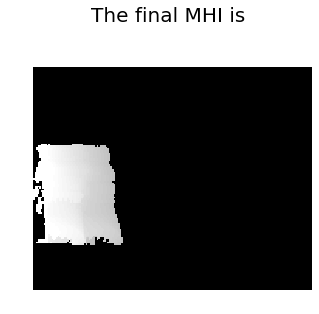

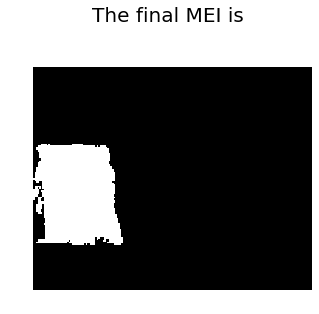

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.17833745703633766, 0.0014990002278840728, 0.019102685812236432, 0.001912611844790683, 0.07968956944478947, 0.0030354547439256155, 0.012212012745299594]
Similitude moments for normalized MEI is:
 [0.1072999910384716, 5.9233757083410625e-05, 0.011099150607876957, 0.0003807959420329486, 0.06701065607406195, 0.0011761547088640796, 0.00018728296726788025]


In [11]:
frame_grabber('daria_walk')
daria_walk = read_files('daria_walk')
frame_grabber('bg_015')
daria_bg = read_files('bg_015')
daria_walk_bs = background_subtraction(daria_walk,daria_bg[0],40)
daria_walk_mhi = MHI(daria_walk_bs,20)
daria_walk_mei = MEI_t(daria_walk_mhi)

daria_walk_mhi_n, daria_walk_mei_n = normalize(daria_walk_mhi, daria_walk_mei)
daria_walk_mhi_sm = similitude_moments(daria_walk_mhi_n)
daria_walk_mei_sm = similitude_moments(daria_walk_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_walk_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_walk_mei_sm)
daria_walk_sm = daria_walk_mhi_sm + daria_walk_mei_sm

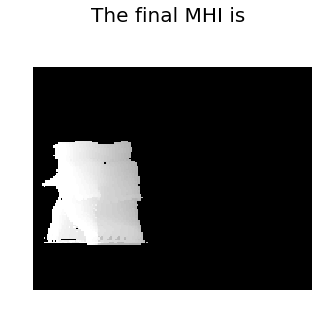

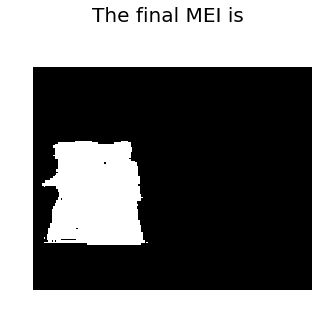

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.15240947594091117, -0.00743810465722797, 0.009408564964094012, -0.0011031847649440253, 0.08673352574066666, 0.006610154773903371, 0.012405608926486882]
Similitude moments for normalized MEI is:
 [0.09942163888888889, -0.0018844363981481511, 0.003056999228395061, -0.0005964845213477372, 0.07197388715277776, 0.0026631104632415985, -0.0003518356500075037]


In [12]:
frame_grabber('denis_walk')
denis_walk = read_files('denis_walk')
frame_grabber('bg_026')
denis_bg = read_files('bg_026')
denis_walk_bs = background_subtraction(denis_walk,denis_bg[0],20)
denis_walk_mhi = MHI(denis_walk_bs,20)
denis_walk_mei = MEI_t(denis_walk_mhi)

denis_walk_mhi_n, denis_walk_mei_n = normalize(denis_walk_mhi, denis_walk_mei)
denis_walk_mhi_sm = similitude_moments(denis_walk_mhi_n)
denis_walk_mei_sm = similitude_moments(denis_walk_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_walk_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_walk_mei_sm)
denis_walk_sm = denis_walk_mhi_sm + denis_walk_mei_sm

# Run

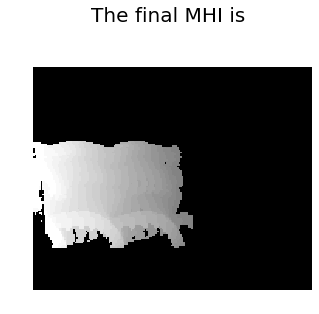

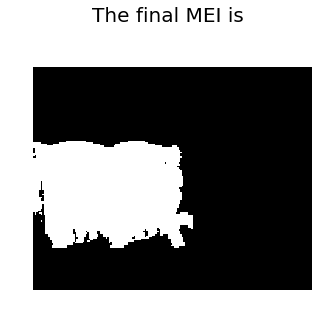

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.10388887590884141, 0.001551604677396186, 0.013463964602287055, 0.0004945373566796537, 0.16455955692171528, 0.0006526132583578437, 0.037496877954984374]
Similitude moments for normalized MEI is:
 [0.056591558220161216, 0.0006571743269265223, 0.0058343766934334925, -0.00014155295490955478, 0.12617249303061226, -0.00010286142389855885, 0.0011001623394331873]


In [13]:
frame_grabber('daria_run')
daria_run = read_files('daria_run')
daria_run_bs = background_subtraction(daria_run,daria_bg[0],40)
daria_run_mhi = MHI(daria_run_bs,20)
daria_run_mei = MEI_t(daria_run_mhi)

daria_run_mhi_n, daria_run_mei_n = normalize(daria_run_mhi, daria_run_mei)
daria_run_mhi_sm = similitude_moments(daria_run_mhi_n)
daria_run_mei_sm = similitude_moments(daria_run_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_run_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_run_mei_sm)
daria_run_sm = daria_run_mhi_sm + daria_run_mei_sm

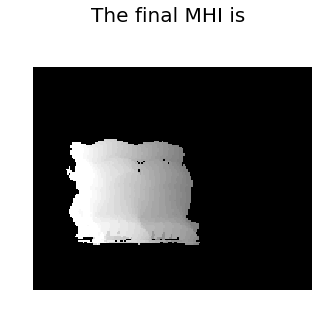

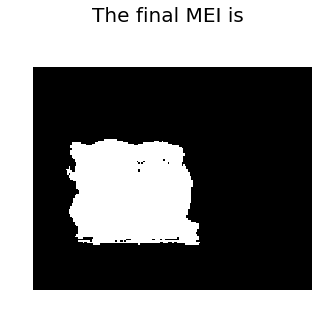

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.12399377720850242, -0.0030131278507283484, 0.016274377045889837, 0.0012405175701229463, 0.12350134797632674, 0.004418310101458265, 0.024753285740686852]
Similitude moments for normalized MEI is:
 [0.07160576937589491, -0.0005484444246532652, 0.00869884322219572, 9.504838657662694e-05, 0.09888360142555803, 0.001623823545125319, 0.0007373264113710397]


In [14]:
frame_grabber('denis_run')
denis_run = read_files('denis_run')
denis_run_bs = background_subtraction(denis_run,denis_bg[0],20)
denis_run_mhi = MHI(denis_run_bs,20)
denis_run_mei = MEI_t(denis_run_mhi)

denis_run_mhi_n, denis_run_mei_n = normalize(denis_run_mhi, denis_run_mei)
denis_run_mhi_sm = similitude_moments(denis_run_mhi_n)
denis_run_mei_sm = similitude_moments(denis_run_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_run_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_run_mei_sm)
denis_run_sm = denis_run_mhi_sm + denis_run_mei_sm

# Skip

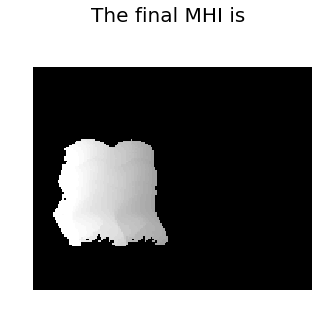

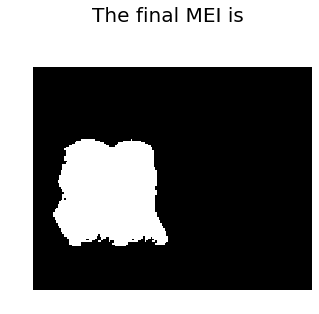

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.14748269864653388, -0.003919749690259042, -0.00023952637405416232, 0.003077128426068086, 0.09786644692537792, 0.004545903237726755, 0.01706873874620287]
Similitude moments for normalized MEI is:
 [0.08604559335179879, -0.0015028348454474841, 0.0031298361252474517, 0.0012114617642756422, 0.08279209587175207, 0.00324404530635373, 0.00039706332963713564]


In [15]:
frame_grabber('daria_skip')
daria_skip = read_files('daria_skip')
daria_skip_bs = background_subtraction(daria_skip,daria_bg[0],40)
daria_skip_mhi = MHI(daria_skip_bs,20)
daria_skip_mei = MEI_t(daria_skip_mhi)

daria_skip_mhi_n, daria_skip_mei_n = normalize(daria_skip_mhi, daria_skip_mei)
daria_skip_mhi_sm = similitude_moments(daria_skip_mhi_n)
daria_skip_mei_sm = similitude_moments(daria_skip_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_skip_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_skip_mei_sm)
daria_skip_sm = daria_skip_mhi_sm + daria_skip_mei_sm

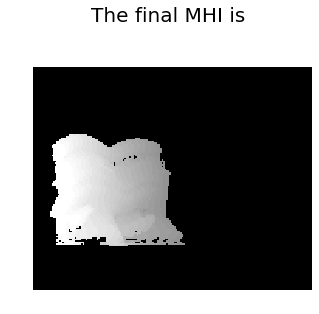

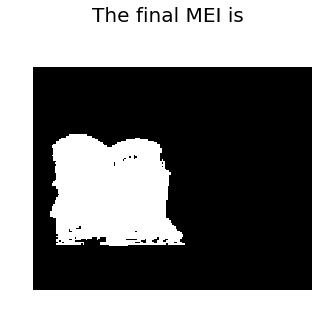

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.136531319334209, -0.002796452928211643, 0.014056426411786288, -0.0007708049929164392, 0.11310122337569822, 0.004591457161271098, 0.02416239133312304]
Similitude moments for normalized MEI is:
 [0.0775821385861437, -0.0008527947118519149, 0.010894913954958552, -3.4737498085262816e-05, 0.09521925622646095, 0.0023363896120942, 0.0012410589880822037]


In [16]:
frame_grabber('denis_skip')
denis_skip = read_files('denis_skip')
denis_skip_bs = background_subtraction(denis_skip,denis_bg[0],20)
denis_skip_mhi = MHI(denis_skip_bs,20)
denis_skip_mei = MEI_t(denis_skip_mhi)

denis_skip_mhi_n, denis_skip_mei_n = normalize(denis_skip_mhi, denis_skip_mei)
denis_skip_mhi_sm = similitude_moments(denis_skip_mhi_n)
denis_skip_mei_sm = similitude_moments(denis_skip_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_skip_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_skip_mei_sm)
denis_skip_sm = denis_skip_mhi_sm + denis_skip_mei_sm

# Bend

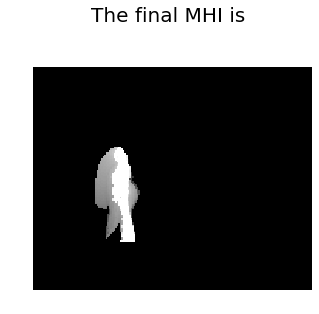

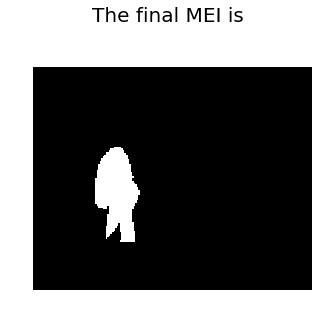

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.28076435626480173, 0.031319055881177414, 0.033564142170856286, 0.012337071371125625, 0.04439198191945915, 0.0015003529104396132, -0.0038189681072370958]
Similitude moments for normalized MEI is:
 [0.19511822186712946, 0.012134814615440076, 0.020491456301066573, 0.005978653154514075, 0.03910601502350061, 0.0008792192316571996, -0.0009621500745408682]


In [17]:
frame_grabber('daria_bend')
daria_bend = read_files('daria_bend')
daria_bend_bs = background_subtraction(daria_bend,daria_bg[0],40)
daria_bend_mhi = MHI(daria_bend_bs,83)
daria_bend_mei = MEI_t(daria_bend_mhi)

daria_bend_mhi_n, daria_bend_mei_n = normalize(daria_bend_mhi, daria_bend_mei)
daria_bend_mhi_sm = similitude_moments(daria_bend_mhi_n)
daria_bend_mei_sm = similitude_moments(daria_bend_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_bend_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_bend_mei_sm)
daria_bend_sm = daria_bend_mhi_sm + daria_bend_mei_sm

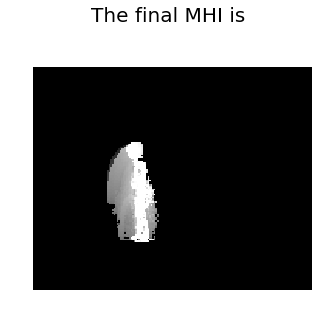

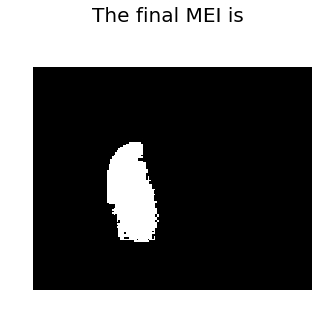

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.24941628604780613, -0.006128793509632808, 0.026746949677841504, 0.003218282077523666, 0.04646237367283601, 0.0020438807754362175, -0.002791478811368058]
Similitude moments for normalized MEI is:
 [0.1809624038036457, -0.005959832813020354, 0.023004913870119797, 0.002627425918505052, 0.04009523000812091, 0.001854041769710785, 5.4776117856320174e-05]


In [18]:
frame_grabber('denis_bend')
denis_bend = read_files('denis_bend')
denis_bend_bs = background_subtraction(denis_bend,denis_bg[0],30)
denis_bend_mhi = MHI(denis_bend_bs,83)
denis_bend_mei = MEI_t(denis_bend_mhi)

denis_bend_mhi_n, denis_bend_mei_n = normalize(denis_bend_mhi, denis_bend_mei)
denis_bend_mhi_sm = similitude_moments(denis_bend_mhi_n)
denis_bend_mei_sm = similitude_moments(denis_bend_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_bend_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_bend_mei_sm)
denis_bend_sm = denis_bend_mhi_sm + denis_bend_mei_sm

# Jack

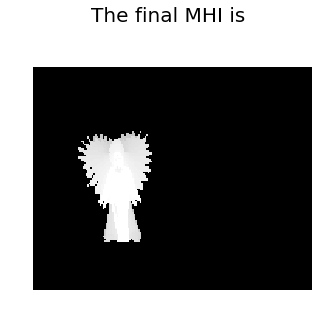

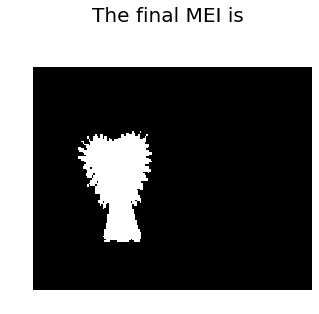

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.19567162841945496, 0.03307606627160179, 0.011322356678352493, 0.0046959641127967845, 0.0604588943340577, -0.012267483377307329, -0.0036443724154457315]
Similitude moments for normalized MEI is:
 [0.17230632744579433, 0.03155646023335846, 0.011066493196103054, 0.004197526341393747, 0.051229353420229405, -0.008264128794524017, -0.002440134413073434]


In [19]:
frame_grabber('daria_jack')
daria_jack = read_files('daria_jack')
daria_jack_bs = background_subtraction(daria_jack,daria_bg[0],40)
daria_jack_mhi = MHI(daria_jack_bs,20)
daria_jack_mei = MEI_t(daria_jack_mhi)

daria_jack_mhi_n, daria_jack_mei_n = normalize(daria_jack_mhi, daria_jack_mei)
daria_jack_mhi_sm = similitude_moments(daria_jack_mhi_n)
daria_jack_mei_sm = similitude_moments(daria_jack_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_jack_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_jack_mei_sm)
daria_jack_sm = daria_jack_mhi_sm + daria_jack_mei_sm

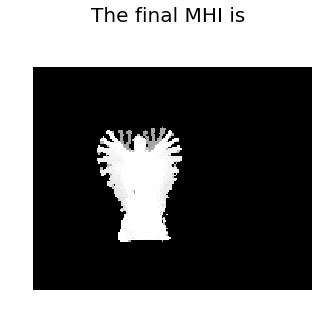

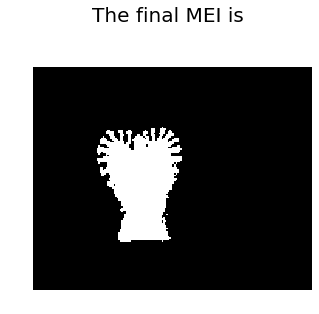

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.1553248889049467, 0.015777444176672643, 0.008225478161206647, 4.948109449974634e-06, 0.061680256462363504, -0.010182765108446668, -0.0021090811329607917]
Similitude moments for normalized MEI is:
 [0.14542715989763763, 0.01613366061397624, 0.0065729916807375855, 0.0010979808014812934, 0.05754874628372852, -0.00781812775225494, -0.0018659419544758212]


In [20]:
frame_grabber('denis_jack')
denis_jack = read_files('denis_jack')
denis_jack_bs = background_subtraction(denis_jack,denis_bg[0],20)
denis_jack_mhi = MHI(denis_jack_bs,20)
denis_jack_mei = MEI_t(denis_jack_mhi)

denis_jack_mhi_n, denis_jack_mei_n = normalize(denis_jack_mhi, denis_jack_mei)
denis_jack_mhi_sm = similitude_moments(denis_jack_mhi_n)
denis_jack_mei_sm = similitude_moments(denis_jack_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_jack_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_jack_mei_sm)
denis_jack_sm = denis_jack_mhi_sm + denis_jack_mei_sm

# One hand wave

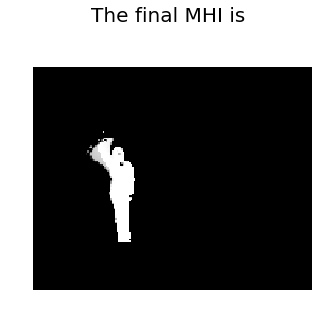

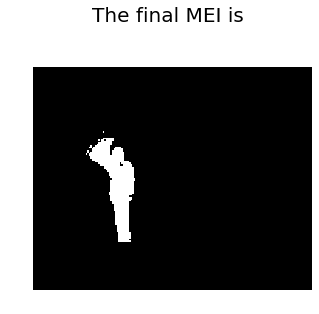

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.3652734684311937, 0.08219018459774033, 0.06870434571138072, -0.008092232034176514, 0.04363537651650387, -0.013843342059454082, -0.006418696366233296]
Similitude moments for normalized MEI is:
 [0.34748059250727786, 0.08478648548275894, 0.07221932434028636, -0.0046219990312927044, 0.04747281291240165, -0.013540136432670427, -0.0072719253553640015]


In [21]:
frame_grabber('daria_wave1')
daria_wave1 = read_files('daria_wave1')
daria_wave1_bs = background_subtraction(daria_wave1,daria_bg[0],40)
daria_wave1_mhi = MHI(daria_wave1_bs,83)
daria_wave1_mei = MEI_t(daria_wave1_mhi)

daria_wave1_mhi_n, daria_wave1_mei_n = normalize(daria_wave1_mhi, daria_wave1_mei)
daria_wave1_mhi_sm = similitude_moments(daria_wave1_mhi_n)
daria_wave1_mei_sm = similitude_moments(daria_wave1_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_wave1_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_wave1_mei_sm)
daria_wave1_sm = daria_wave1_mhi_sm + daria_wave1_mei_sm

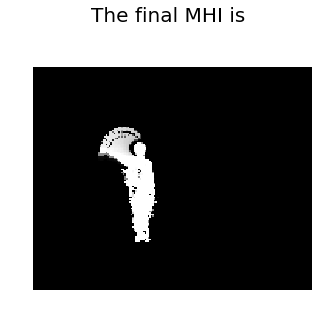

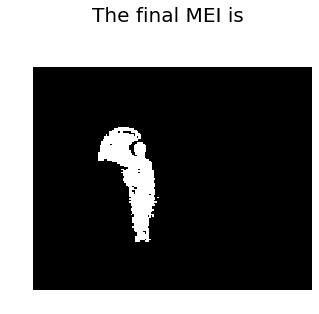

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.32314410165290897, 0.055957900539862014, 0.08180899136260258, -0.006356300310922404, 0.058242975831760795, -0.014502767060285202, -0.010259214954692196]
Similitude moments for normalized MEI is:
 [0.28745784834838684, 0.06174041094946193, 0.07742230876771257, 0.003063830034004448, 0.05924006274191615, -0.009732606395034715, -0.008967416407372517]


In [22]:
frame_grabber('denis_wave1')
denis_wave1 = read_files('denis_wave1')
denis_wave1_bs = background_subtraction(denis_wave1,denis_bg[0],30)
denis_wave1_mhi = MHI(denis_wave1_bs,83)
denis_wave1_mei = MEI_t(denis_wave1_mhi)

denis_wave1_mhi_n, denis_wave1_mei_n = normalize(denis_wave1_mhi, denis_wave1_mei)
denis_wave1_mhi_sm = similitude_moments(denis_wave1_mhi_n)
denis_wave1_mei_sm = similitude_moments(denis_wave1_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_wave1_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_wave1_mei_sm)
denis_wave1_sm = denis_wave1_mhi_sm + denis_wave1_mei_sm